In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-05-21 07:35:05.692728: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [6]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
from config import *
import json

In [7]:
def intervalToMilliseconds(interval):
    """Convert a Binance interval string to milliseconds

    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str

    :return:
        None if unit not one of m, h, d or w
        None if string not in correct format
        int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms= int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

In [8]:
path = "18-01-01-00-00-23-05-20-05-55-1h" #

table = np.load( os.path.join( Config['BinanceCandlesNumpy'], "table-" + path + ".npy") )
table = np.swapaxes(table, 0, 1)
print("table: {}".format(table.shape))

table: (47137, 336, 10)


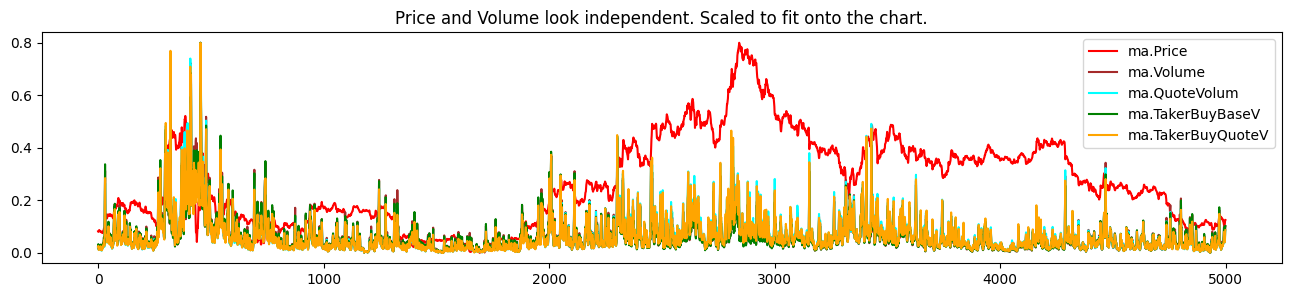

In [9]:
from Mike_NB_01 import *

market = 5
Show_Price_Volume_10(table[:, market, :], 1, 1, 5000)

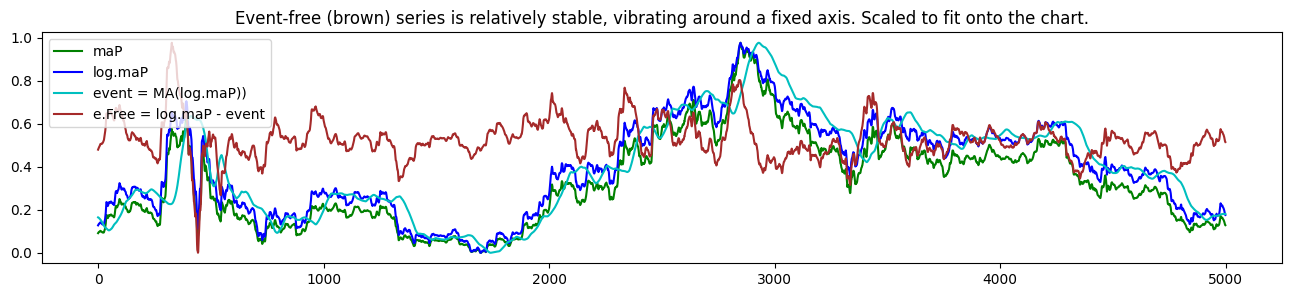

In [10]:
Event_Free_Learning_Scheme_10(table[:, market, :], 3, 30, 5000)

In [11]:
marks = table[:, :, 9] # keep it for later use

table = np.delete(table, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, Marks

from enum import Enum
class Fields(Enum):
    Close = 0       # closing price
    Volume = 1      # base volume
    bVolume = 2     # buyer base volume

table_markets = []
with open( os.path.join( Config['BinanceCandlesNumpy'], "reports-" + path + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert table.shape[1] == len(markets)
print(table.shape, len(markets), markets[:2])

['ALICEUSDT: 47137, 28074 created. Success.', 'DOTUSDT: 47137, 23082 created. Success.']
(47137, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [12]:

# Add time features

start = datetime( 2000+int(path[0:2]), int(path[3:5]), int(path[6:8]), int(path[9:11]), int(path[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = path[ path.find('-', len(path) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps = np.array( range(start_ts, start_ts + table.shape[1] * interval_s, interval_s), dtype=int)
assert timestamps.shape[0] == table.shape[1]
print(start_ts, interval_s, timestamps.shape, timestamps[:3])

# A normalized representation of 'timestamps'
time_of_year_sin = np.sign( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_year_cos = np.cos( 2 * np.pi / (60*60*24*365) * timestamps )
time_of_week_sin = np.sign( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_week_cos = np.cos( 2 * np.pi / (60*60*24*7) * timestamps )
time_of_day_sin = np.sign( 2 * np.pi / (60*60*24) * timestamps )
time_of_day_cos = np.cos( 2 * np.pi / (60*60*24) * timestamps )


1514764800 3600 (336,) [1514764800 1514768400 1514772000]


In [13]:
# Find market clusters
from sklearn.metrics import pairwise

distances = np.zeros( (table.shape[1], table.shape[1]), dtype=float)

# Find dependency distance
for m in range(table.shape[1]):
    distances[m, m] = 0.
    for n in range(m+1, table.shape[1]):
        mask = (marks[:, m] + marks[:, n] == 0) # marks == 0 : true full candles, marks = -1: price interpolated , marks = -2: coincodex prices
        pm = table[mask, m, 0][np.newaxis]
        pn = table[mask, n, 0][np.newaxis]
        distances[m, n] = sklearn.metrics.pairwise.cosine_distances(pm, pn)
        distances[n, m] = distances[m, n]

In [14]:
markets[2]

'1INCHUSDT'

In [15]:
from sklearn.cluster import OPTICS
clustering = OPTICS(metric='precomputed', n_jobs=-1).fit(distances)
print( clustering.labels_ )

np.reshape(np.argwhere(clustering.labels_ == 1), -1)

market_clusters = [ [ markets[ id ] for id in np.reshape(np.argwhere(clustering.labels_ == label), -1) ] for label in range(np.max(clustering.labels_))]
print(market_clusters)

[-1  2 -1  2  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  2 -1 -1 -1  2  2 -1
 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1  1 -1 -1  1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  2 -1 -1 -1
 -1  1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

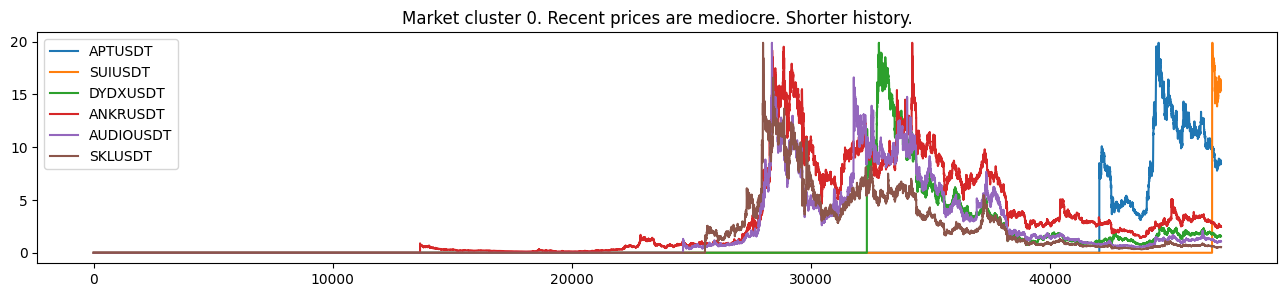

In [16]:
cluster = 0
ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
series = [ [table[:, id, 0], markets[id] ] for id in ids ]
PoltNormalized("Market cluster 0. Recent prices are mediocre. Shorter history.", series, color = 'auto')

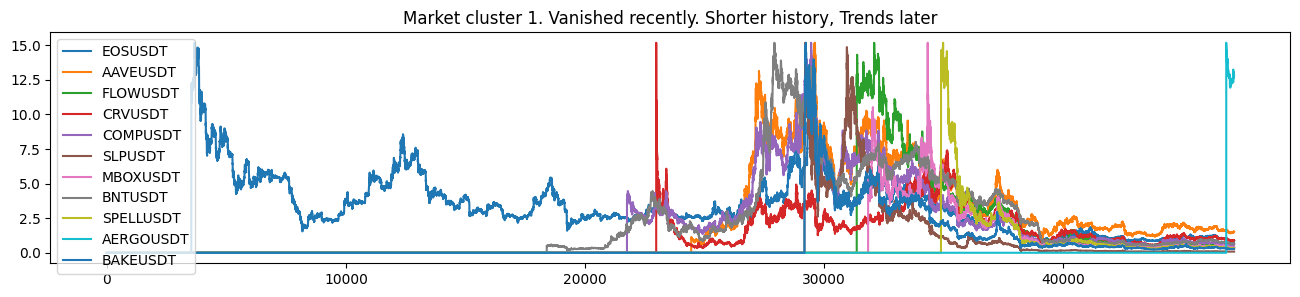

In [17]:
cluster = 1
ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
series = [ [table[:, id, 0], markets[id] ] for id in ids ]
PoltNormalized("Market cluster 1. Vanished recently. Shorter history, Trends later", series, color = 'auto')

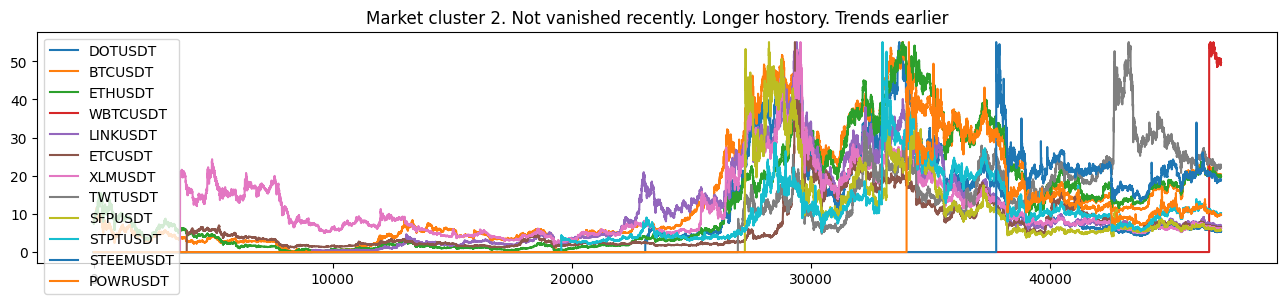

In [18]:
cluster = 2
ids = np.reshape(np.argwhere(clustering.labels_ == cluster), -1)
series = [ [table[:, id, 0], markets[id] ] for id in ids ]
PoltNormalized("Market cluster 2. Not vanished recently. Longer hostory. Trends earlier", series, color = 'auto')

In [87]:
def save_to_multiple_csv_files(data, sample_anchors, name_prefix, Nx, size_x, Ny, size_y, header=None, n_parts=10):
    training_dir = os.path.join("/mnt/data/Trading", "Datasets")
    os.makedirs(training_dir, exist_ok=True)
    path_format = os.path.join(training_dir, "{}_{:02d}.csv")

    filenames = []
    for file_idx, sample_anchors in enumerate(np.array_split(sample_anchors, n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for sample_anchor in sample_anchors:
                x = np.reshape(data[sample_anchor: sample_anchor + Nx], -1)
                f.write(",".join([str(col) for col in x]))
                y = np.reshape(data[sample_anchor + Nx: sample_anchor + Nx + Ny], -1)
                f.write("," + ",".join([str(col) for col in y]))
                f.write("\n")
    return filenames

In [ ]:
def parse_csv_line(line, n_inputs = Nx + Ny):
    defs = [tf.constant(np.nan)] * (n_inputs + 1)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:Nx])
    y = tf.stack(fields[Nx:])
    return x, y

In [ ]:
def csv_reader_dataset(filenames, n_parse_threads=5, batch_size=32,
                       shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename), #.skip(1),
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    # dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    # dataset = dataset.batch(batch_size)
    return dataset #.prefetch(1)

In [ ]:
# Do NOT create x an y, as they will be too large for the memory.
# Instead, create a splitting plan.

Dim = 10
Nx = 4
Ny = 2
Ns = 1000
sizeBatch = 64

nSamples = int ( (table.shape[0] - Nx - Ny) / Ns ) + 1
anchors = range(0, table.shape[0] - Nx - Ny, Ns)
assert nSamples == len(anchors)
nBatches = int( nSamples / sizeBatch )


print(table.shape[0], nSamples, nBatches, len(anchors))

In [88]:
data = table[:, :2, :2]
filenames = save_to_multiple_csv_files(data, anchors, path, Nx, Ny, header=None, n_parts=10)

In [89]:
filename_dataset = tf.data.Dataset.list_files(filenames)
print(filename_dataset.cardinality().numpy())
filename_dataset.repeat()
print(filename_dataset.cardinality().numpy())

10
10


In [90]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filenames[0]),
    cycle_length=n_readers)

In [91]:
for line in dataset.take(15):
    print(line.numpy())

b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'
b'0.0,0.0,

In [98]:
Dataset = csv_reader_dataset(filenames)

In [99]:
for element in Dataset:
    print(element)

tf.Tensor(b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0', shape=(), dtype=string)
tf.Tensor(b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0', shape=(), dtype=string)
tf.Tensor(b'7.1019,156936.23,26.261,767859.3,6.7497,661769.06,25.37,2454681.2,6.7703,331691.88,25.309,1188740.4,6.8026,153822.9,25.788,941994.25,6.6967,124537.25,25.023,947358.06,6.3718,376692.56,24.673,1836211.9', shape=(), dtype=string)
tf.Tensor(b'1.126,17700.33,4.643,42962.73,1.127,27425.21,4.67,859629.7,1.129,15879.73,4.67,91056.75,1.131,49747.64,4.663,36806.21,1.129,13516.39,4.666,45346.88,1.129,25244.23,4.689,75786.1', shape=(), dtype=string)
tf.Tensor(b'13.01,103342.82,28.18,274678.97,13.03,150229.4,28.31,480944.56,13.02,133533.19,28.28,189394.64,13.02,97398.37,28.4,239430.31,12.59,327948.6,27.8,683074.7,12.69,345084.97,27.8,828406.6', shape=(), dtype=string)
tf.Tensor(b'0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [58]:
print(Dataset.take(1), Dataset[0])

# for X_batch, y_batch in Dataset.take(2):
#     print("X =", X_batch)
#     print("y =", y_batch)
#     print()

TypeError: 'InterleaveDataset' object is not subscriptable